In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
class RBFNetwork:
    def __init__(self, num_centers,alpha=0.0):
        self.num_centers = num_centers
        self.alpha = alpha
        self.centers = None
        self.widths = None
        self.linear_regressor = LinearRegression()

    def _rbf(self, x, center, width):
        return np.exp(-np.linalg.norm(x - center) ** 2 / (2 * width ** 2))

    def fit(self, X, y):
        print("Starting the fit method.")
        kmeans = KMeans(n_clusters=self.num_centers, random_state=42).fit(X)
        self.centers = kmeans.cluster_centers_
        print(f"Centers found: {self.centers}")

        d_max = np.max([np.linalg.norm(c1 - c2) for c1 in self.centers for c2 in self.centers])
        self.widths = np.full(self.num_centers, d_max / np.sqrt(2 * self.num_centers))
        print(f"Widths calculated: {self.widths}")

        R = np.zeros((X.shape[0], self.num_centers))
        for i in range(X.shape[0]):
            for j in range(self.num_centers):
                R[i, j] = self._rbf(X[i], self.centers[j], self.widths[j])
        print(f"RBF activations: {R}")

        self.linear_regressor.fit(R, y)
        print("Finished training the linear regressor.")

    def predict(self, X):
        print("Starting the predict method.")
        R = np.zeros((X.shape[0], self.num_centers))
        for i in range(X.shape[0]):
            for j in range(self.num_centers):
                R[i, j] = self._rbf(X[i], self.centers[j], self.widths[j])
        predictions = self.linear_regressor.predict(R)
        print(f"Predictions: {predictions}")
        return predictions

def load_data(file_path):
    data = pd.read_excel(file_path)
    # Assuming columns: 'Temperature', 'Humidity', 'Historical Load', 'Load'
    power_column = data['POWER (KW)']
    max_power = power_column.max()
    data['Normalized POWER (KW)'] = power_column / max_power
    # Create lagged features
    data['Load_Lag_1'] = data['POWER (KW)'].shift(1)     # Previous hour
    data['Load_Lag_24'] = data['POWER (KW)'].shift(24)   # Previous day
    data['Load_Lag_168'] = data['POWER (KW)'].shift(168) # Previous week
    data.dropna(inplace=True)
    feature_cols = ['POWER (KW)','"WEEKEND/WEEKDAY"', 'SEASON', 'Load_Lag_1','Load_Lag_24','Load_Lag_168','Temp (F)', 'Humidity (%)']
    target_col = 'Normalized POWER (KW)'
    X = data[feature_cols].values
    y = data[target_col].values
    return train_test_split(X, y, test_size=0.2, random_state=42)
file_path = '/content/testclusters removed.xlsx'
X_train, X_test, y_train, y_test = load_data(file_path)

# Create and train the RBF network
rbf_net = RBFNetwork(num_centers=10)
rbf_net.fit(X_train, y_train)

# Predict using the trained RBF network
y_pred = rbf_net.predict(X_test)

ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [ ]:
def custom_scorer(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)

In [ ]:
class RBFNetworkWrapper:
    def __init__(self, num_centers, alpha):
        self.num_centers = num_centers
        self.alpha = alpha
        self.model = RBFNetwork(num_centers=num_centers, alpha=alpha)

    def fit(self, X, y):
        self.model.fit(X, y)

    def predict(self, X):
        return self.model.predict(X)

    def get_params(self, deep=True):
        return {'num_centers': self.num_centers, 'alpha': self.alpha}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        self.model = RBFNetwork(num_centers=self.num_centers, alpha=self.alpha)
        return self
param_grid = {
    'num_centers': [5, 10, 15],
    'alpha': [0.1, 1.0, 10.0]
}
kf = KFold(n_splits=5)

# Set up and run grid search
grid_search = GridSearchCV(
    estimator=RBFNetworkWrapper(10, 1.0),
    param_grid=param_grid,
    scoring=make_scorer(custom_scorer, greater_is_better=False),
    cv=kf,
    verbose=2
)

grid_search.fit(X_train, y_train)

# Best model
best_model = grid_search.best_estimator_.model

# Make predictions
y_pred = best_model.predict(X_test)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Starting the fit method.


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Centers found: [[1.05949855e+03 2.11538462e-01 8.46153846e-01 4.21817407e+03
  1.09580304e+03 1.03786525e+03 7.40480769e+01 8.33173077e+01]
 [1.17977461e+03 1.37724551e-01 1.01077844e+00 1.20452570e+03
  1.18203904e+03 1.19215977e+03 8.09233533e+01 7.59604790e+01]
 [4.67951937e+03 1.80851064e-01 1.35106383e+00 4.11853134e+03
  4.74411875e+03 4.82929544e+03 9.14574468e+01 3.58829787e+01]
 [3.51701486e+03 1.24352332e-01 8.49740933e-01 3.08268188e+03
  3.24912129e+03 2.28197658e+03 8.35544041e+01 5.74559585e+01]
 [1.97664027e+03 1.45454545e-01 9.84090909e-01 1.61508129e+03
  2.15719515e+03 2.64854779e+03 8.19431818e+01 6.47954545e+01]]
Widths calculated: [2160.05849988 2160.05849988 2160.05849988 2160.05849988 2160.05849988]
RBF activations: [[0.46535007 0.90914523 0.01269021 0.34075055 0.66296454]
 [0.00577245 0.00182655 0.89552633 0.15424858 0.02504961]
 [0.26659219 0.91921599 0.00693708 0.22819463 0.61596186]
 ...
 [0.26325993 0.94725011 0.00280673 0.12379945 0.51916132]
 [0.55332514 0

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Centers found: [[1.97741075e+03 1.56599553e-01 9.70917226e-01 1.63749170e+03
  2.12385922e+03 2.62010373e+03 8.16085011e+01 6.59686801e+01]
 [4.56055140e+03 1.86813187e-01 1.29120879e+00 3.94127318e+03
  4.65553495e+03 4.78150928e+03 9.14945055e+01 3.72912088e+01]
 [1.16331954e+03 1.35714286e-01 9.52380952e-01 1.19362317e+03
  1.16821301e+03 1.16669972e+03 8.07130952e+01 7.68535714e+01]
 [3.55708095e+03 1.07526882e-01 8.44086022e-01 3.18057924e+03
  3.14482249e+03 2.15847620e+03 8.32741935e+01 5.84784946e+01]
 [1.07530520e+03 1.69811321e-01 8.77358491e-01 4.18608582e+03
  1.14695409e+03 1.08804665e+03 7.38490566e+01 8.27358491e+01]]
Widths calculated: [2105.24841523 2105.24841523 2105.24841523 2105.24841523 2105.24841523]
RBF activations: [[0.83641425 0.02281308 0.87150314 0.34261026 0.34768773]
 [0.7317696  0.00926182 0.94364097 0.19388661 0.26180899]
 [0.56973209 0.00433106 0.97630458 0.14197066 0.36325138]
 ...
 [0.50803402 0.00291991 0.94829686 0.11116154 0.25129738]
 [0.52975356 0

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Centers found: [[3.58819911e+03 1.28205128e-01 8.41025641e-01 3.17153993e+03
  3.18952693e+03 2.30641231e+03 8.34512821e+01 5.94512821e+01]
 [1.17407191e+03 1.37349398e-01 9.80722892e-01 1.19423683e+03
  1.16584256e+03 1.18622290e+03 8.10337349e+01 7.58084337e+01]
 [4.68508753e+03 1.90217391e-01 1.36413043e+00 4.03962543e+03
  4.77145090e+03 4.79369634e+03 9.15760870e+01 3.54782609e+01]
 [1.99461933e+03 1.52317881e-01 9.66887417e-01 1.64504017e+03
  2.18961966e+03 2.59131290e+03 8.12935982e+01 6.55253863e+01]
 [1.08836090e+03 1.91919192e-01 9.69696970e-01 4.20032675e+03
  1.12810577e+03 1.09564027e+03 7.41515152e+01 8.18585859e+01]]
Widths calculated: [2154.98215484 2154.98215484 2154.98215484 2154.98215484 2154.98215484]
RBF activations: [[0.34490493 0.87836927 0.02185227 0.84646068 0.36074116]
 [0.19971009 0.94877689 0.00891759 0.7330602  0.27594225]
 [0.14494693 0.97713398 0.00425588 0.57571025 0.37731182]
 ...
 [0.1142546  0.94882749 0.00290053 0.51860525 0.26444561]
 [0.17768386 0

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Centers found: [[4.67420703e+03 2.04968944e-01 1.31677019e+00 4.00631071e+03
  4.73023022e+03 4.79019816e+03 9.15403727e+01 3.70559006e+01]
 [1.99686460e+03 1.53846154e-01 8.95104895e-01 1.64809664e+03
  2.17579305e+03 2.61989210e+03 8.19370629e+01 6.50792541e+01]
 [1.07536664e+03 1.49532710e-01 8.69158879e-01 4.23919248e+03
  1.10537760e+03 1.07468492e+03 7.35140187e+01 8.31214953e+01]
 [1.17380006e+03 1.33794694e-01 9.85005767e-01 1.20175639e+03
  1.17822300e+03 1.18043951e+03 8.08754325e+01 7.57485582e+01]
 [3.49599422e+03 1.37055838e-01 8.93401015e-01 3.14072155e+03
  3.18452924e+03 2.23247748e+03 8.29898477e+01 5.95939086e+01]]
Widths calculated: [2139.32460596 2139.32460596 2139.32460596 2139.32460596 2139.32460596]
RBF activations: [[0.0217849  0.83853235 0.34400668 0.87885269 0.36369928]
 [0.00888774 0.72742002 0.2620063  0.94672137 0.20926046]
 [0.00420235 0.56806913 0.36306973 0.97586752 0.15356276]
 ...
 [0.00285137 0.50942906 0.25200394 0.94756707 0.12185254]
 [0.0050375  0

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Centers found: [[1.94215825e+03 1.40589569e-01 9.25170068e-01 1.60944395e+03
  2.13270981e+03 2.56727647e+03 8.15941043e+01 6.56122449e+01]
 [4.61511716e+03 1.58163265e-01 1.32653061e+00 3.95012071e+03
  4.69857572e+03 4.80469263e+03 9.13367347e+01 3.62500000e+01]
 [3.52949651e+03 1.34020619e-01 8.60824742e-01 3.14875364e+03
  3.16859763e+03 2.17693789e+03 8.31701031e+01 6.03969072e+01]
 [1.17647702e+03 1.45808019e-01 9.72053463e-01 1.20462055e+03
  1.17779415e+03 1.17757894e+03 8.08590522e+01 7.64592953e+01]
 [1.08679020e+03 1.68224299e-01 9.06542056e-01 4.32547604e+03
  1.12245363e+03 1.04260782e+03 7.32710280e+01 8.27570093e+01]]
Widths calculated: [2119.33009053 2119.33009053 2119.33009053 2119.33009053 2119.33009053]
RBF activations: [[8.54137898e-01 2.20275839e-02 3.54017592e-01 8.76585130e-01
  3.19024502e-01]
 [7.48020400e-01 8.96266543e-03 2.01678495e-01 9.45278424e-01
  2.38021720e-01]
 [5.88183383e-01 4.18736753e-03 1.47762132e-01 9.75239562e-01
  3.34811400e-01]
 ...
 [9.06

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Centers found: [[4.81398927e+03 1.98113208e-01 1.45283019e+00 4.97393826e+03
  4.83927123e+03 4.93226069e+03 9.17452830e+01 3.30660377e+01]
 [2.06728598e+03 1.35593220e-01 7.49152542e-01 1.83125496e+03
  2.00707325e+03 1.63306699e+03 7.70033898e+01 7.08000000e+01]
 [1.32605416e+03 1.18773946e-01 1.07662835e+00 1.13080522e+03
  1.38581630e+03 2.04042485e+03 8.41417625e+01 6.83563218e+01]
 [2.34492789e+03 1.61290323e-01 6.45161290e-01 1.25156127e+03
  3.82330758e+03 2.66888475e+03 8.34032258e+01 7.13387097e+01]
 [1.06065612e+03 2.19047619e-01 8.47619048e-01 4.20375797e+03
  1.09681914e+03 1.03904743e+03 7.40095238e+01 8.33523810e+01]
 [4.40647554e+03 1.07142857e-01 5.17857143e-01 4.15654890e+03
  4.09214772e+03 2.18586368e+03 8.46607143e+01 4.80178571e+01]
 [1.04135650e+03 1.40350877e-01 1.08947368e+00 1.17183617e+03
  1.05807314e+03 1.01405811e+03 8.02807018e+01 7.78263158e+01]
 [4.55696588e+03 1.76470588e-01 1.38235294e+00 2.57970198e+03
  4.79457688e+03 4.92788307e+03 9.25588235e+01 3

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Centers found: [[3.20794099e+03 1.33333333e-01 1.11111111e+00 2.86243816e+03
  2.79637544e+03 2.07398935e+03 8.22222222e+01 6.10592593e+01]
 [4.78102462e+03 2.02247191e-01 1.44943820e+00 4.93082518e+03
  4.84933887e+03 4.93343128e+03 9.15056180e+01 3.31460674e+01]
 [1.05438584e+03 1.41353383e-01 9.90977444e-01 1.13702443e+03
  1.06457731e+03 1.08311922e+03 8.05187970e+01 7.80992481e+01]
 [2.16557666e+03 8.33333333e-02 9.66666667e-01 1.01576330e+03
  3.36335067e+03 2.31163811e+03 8.01833333e+01 7.47833333e+01]
 [1.07915341e+03 1.73076923e-01 8.55769231e-01 4.19798427e+03
  1.15205816e+03 1.04667675e+03 7.38653846e+01 8.29423077e+01]
 [4.35569737e+03 9.67741935e-02 3.87096774e-01 4.24620474e+03
  3.89443321e+03 2.28496855e+03 8.49516129e+01 5.24032258e+01]
 [1.94822092e+03 1.56050955e-01 7.54777070e-01 1.74143495e+03
  1.86729096e+03 1.61665973e+03 7.74968153e+01 7.17707006e+01]
 [4.41369056e+03 1.55844156e-01 1.24675325e+00 2.58669894e+03
  4.70464153e+03 4.76515392e+03 9.24415584e+01 3

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Centers found: [[1.01781281e+03 1.49812734e-01 1.02996255e+00 1.17924533e+03
  1.03660278e+03 9.70460497e+02 8.01104869e+01 7.82191011e+01]
 [4.82369570e+03 2.34042553e-01 1.43617021e+00 4.99056439e+03
  4.91762951e+03 4.95601544e+03 9.15638298e+01 3.27553191e+01]
 [2.24397990e+03 1.53846154e-01 8.23076923e-01 2.07829744e+03
  2.11687740e+03 1.69289121e+03 7.71500000e+01 7.02230769e+01]
 [3.31235426e+03 1.17021277e-01 1.14893617e+00 3.21467640e+03
  2.99353821e+03 3.55503491e+03 8.57021277e+01 6.09255319e+01]
 [1.11012359e+03 1.91919192e-01 9.89898990e-01 4.21490434e+03
  1.11763659e+03 1.09576726e+03 7.40404040e+01 8.17676768e+01]
 [1.89420460e+03 1.34453782e-01 1.25210084e+00 1.64851912e+03
  2.00272966e+03 3.86966053e+03 9.01344538e+01 5.34201681e+01]
 [2.41813891e+03 1.81818182e-01 6.62337662e-01 1.24324416e+03
  3.63656311e+03 2.60323974e+03 8.27012987e+01 7.01298701e+01]
 [4.32530614e+03 1.20481928e-01 4.93975904e-01 3.80854026e+03
  3.79054117e+03 1.91086600e+03 8.46265060e+01 5

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Centers found: [[1.06931427e+03 1.50943396e-01 8.77358491e-01 4.23451699e+03
  1.09623447e+03 1.04440309e+03 7.35094340e+01 8.31226415e+01]
 [4.67327237e+03 1.86440678e-01 1.37288136e+00 2.55682314e+03
  4.80419578e+03 4.93474979e+03 9.25084746e+01 3.45932203e+01]
 [4.52756218e+03 8.77192982e-02 4.38596491e-01 4.00733281e+03
  4.13242102e+03 2.05258361e+03 8.51052632e+01 5.05964912e+01]
 [1.04411218e+03 1.33550489e-01 1.05374593e+00 1.16406887e+03
  1.05853973e+03 1.01932198e+03 8.03322476e+01 7.74429967e+01]
 [2.27262614e+03 1.21739130e-01 8.26086957e-01 2.02740696e+03
  2.18495821e+03 4.09336399e+03 8.96000000e+01 5.33391304e+01]
 [3.24137028e+03 1.85483871e-01 1.19354839e+00 3.00478541e+03
  2.84077504e+03 2.27901186e+03 8.15161290e+01 6.33387097e+01]
 [1.32524502e+03 1.40425532e-01 1.07659574e+00 1.14562674e+03
  1.35754158e+03 2.16205435e+03 8.44723404e+01 6.77617021e+01]
 [4.75164073e+03 2.27272727e-01 1.36363636e+00 4.90938844e+03
  4.79427278e+03 4.86557549e+03 9.15681818e+01 3

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Centers found: [[1.05211661e+03 1.47672552e-01 1.03049759e+00 1.15298606e+03
  1.08061564e+03 1.05975735e+03 8.03948636e+01 7.80321027e+01]
 [3.34009670e+03 1.55038760e-01 1.09302326e+00 2.99963241e+03
  2.90446968e+03 2.18251175e+03 8.22403101e+01 6.33875969e+01]
 [2.01991899e+03 1.40065147e-01 7.00325733e-01 1.80276809e+03
  1.95177650e+03 1.59419208e+03 7.72475570e+01 7.19087948e+01]
 [4.76370113e+03 1.50000000e-01 1.45000000e+00 4.90139619e+03
  4.83962146e+03 4.93676001e+03 9.14300000e+01 3.35400000e+01]
 [1.08150522e+03 1.69811321e-01 9.15094340e-01 4.33505003e+03
  1.11335247e+03 1.03703897e+03 7.31981132e+01 8.26886792e+01]
 [2.03023508e+03 1.35593220e-01 7.79661017e-01 1.09732589e+03
  3.48580448e+03 2.35148031e+03 8.13898305e+01 7.37288136e+01]
 [2.35604682e+03 1.72727273e-01 8.81818182e-01 2.07515453e+03
  2.46998007e+03 4.20572899e+03 9.05363636e+01 5.23000000e+01]
 [4.53048706e+03 1.29629630e-01 4.07407407e-01 4.28041301e+03
  4.16330775e+03 2.21544823e+03 8.50555556e+01 5

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Centers found: [[1.28902626e+03 9.58904110e-02 1.18493151e+00 1.10328232e+03
  1.37528843e+03 2.38902010e+03 8.52328767e+01 6.70136986e+01]
 [4.43627322e+03 9.30232558e-02 5.58139535e-01 4.40004342e+03
  4.17201882e+03 2.06417558e+03 8.39069767e+01 4.64651163e+01]
 [3.15248874e+03 1.29411765e-01 1.25882353e+00 3.07824153e+03
  2.75909442e+03 1.94172196e+03 8.11058824e+01 6.32352941e+01]
 [1.31176266e+03 2.05882353e-01 7.64705882e-01 2.03069714e+03
  1.15857381e+03 1.10131947e+03 7.85955882e+01 8.09926471e+01]
 [2.05862408e+03 1.80000000e-01 1.09000000e+00 1.73614562e+03
  1.98742052e+03 3.93912160e+03 9.00300000e+01 5.34500000e+01]
 [1.06851667e+03 1.93181818e-01 8.75000000e-01 4.43262401e+03
  1.10954698e+03 9.87652177e+02 7.33863636e+01 8.29318182e+01]
 [4.83697964e+03 2.03883495e-01 1.46601942e+00 4.99648689e+03
  4.88138328e+03 4.94606939e+03 9.17864078e+01 3.27864078e+01]
 [4.28176709e+03 2.40000000e-01 4.00000000e-01 2.00373531e+03
  3.99200195e+03 2.01314949e+03 8.73600000e+01 4

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Centers found: [[1.31366445e+03 1.70370370e-01 7.85185185e-01 1.99240980e+03
  1.13547529e+03 1.06139048e+03 7.98370370e+01 7.86296296e+01]
 [4.79842791e+03 2.06896552e-01 1.44827586e+00 4.94467758e+03
  4.88606570e+03 4.94014910e+03 9.15172414e+01 3.30919540e+01]
 [2.08558904e+03 1.45833333e-01 1.00000000e+00 1.83704258e+03
  2.17629158e+03 4.13137519e+03 9.06562500e+01 5.15937500e+01]
 [1.07921857e+03 1.42857143e-01 9.01098901e-01 4.37727455e+03
  1.15794338e+03 1.03904024e+03 7.31978022e+01 8.23516484e+01]
 [9.03886579e+02 1.38461538e-01 1.07435897e+00 1.00252319e+03
  9.19528444e+02 9.80040205e+02 8.01256410e+01 7.94564103e+01]
 [3.01517988e+03 1.50000000e-01 1.48750000e+00 2.95982295e+03
  2.92244574e+03 2.31533327e+03 8.03875000e+01 6.69625000e+01]
 [1.43165001e+03 1.21863799e-01 8.56630824e-01 1.09777025e+03
  1.50162423e+03 1.36715183e+03 8.10465950e+01 7.37956989e+01]
 [4.87619637e+03 1.76470588e-01 1.39215686e+00 2.50837371e+03
  5.02176255e+03 4.99605172e+03 9.29019608e+01 3

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Centers found: [[3.11747065e+03 1.94805195e-01 1.18181818e+00 3.03403914e+03
  2.51760954e+03 1.84540289e+03 8.01038961e+01 6.46233766e+01]
 [4.92444601e+03 1.60714286e-01 1.48214286e+00 2.57237640e+03
  4.98088251e+03 5.04893559e+03 9.32321429e+01 3.03750000e+01]
 [9.28058582e+02 1.33879781e-01 1.06830601e+00 1.03697352e+03
  9.43318110e+02 9.09569372e+02 7.99453552e+01 7.90437158e+01]
 [2.04271413e+03 1.47058824e-01 1.08823529e+00 1.73744017e+03
  2.19856784e+03 4.04100910e+03 9.06960784e+01 5.17352941e+01]
 [1.09513596e+03 1.64556962e-01 9.87341772e-01 4.49078614e+03
  1.13972675e+03 1.08510442e+03 7.30632911e+01 8.13037975e+01]
 [1.71635730e+03 1.01694915e-01 5.67796610e-01 1.15551039e+03
  2.03589146e+03 1.13040492e+03 7.83898305e+01 7.79237288e+01]
 [4.41774158e+03 8.33333333e-02 4.58333333e-01 4.45891398e+03
  4.08544771e+03 1.97256493e+03 8.42708333e+01 5.12083333e+01]
 [4.83644631e+03 2.36559140e-01 1.43010753e+00 5.00272926e+03
  4.92424879e+03 4.95799095e+03 9.14731183e+01 3

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Centers found: [[9.26453568e+02 1.32075472e-01 1.15566038e+00 1.03985441e+03
  9.43034331e+02 9.77069963e+02 8.06745283e+01 7.72547170e+01]
 [2.08194186e+03 1.42857143e-01 1.01020408e+00 1.81579533e+03
  1.93056977e+03 3.88479497e+03 8.97551020e+01 5.26836735e+01]
 [3.33335006e+03 1.33333333e-01 1.15555556e+00 1.27621822e+03
  3.22204705e+03 2.20015655e+03 8.20000000e+01 5.88666667e+01]
 [4.81741626e+03 2.43902439e-01 1.41463415e+00 4.97155080e+03
  4.88698562e+03 4.90755968e+03 9.17195122e+01 3.41829268e+01]
 [1.25628055e+03 1.32596685e-01 1.07182320e+00 1.11421552e+03
  1.30868510e+03 2.24641532e+03 8.48232044e+01 6.82983425e+01]
 [1.08000143e+03 1.25000000e-01 9.20454545e-01 4.48456433e+03
  1.11484535e+03 1.03254313e+03 7.23750000e+01 8.27840909e+01]
 [2.13584868e+03 1.82266010e-01 7.53694581e-01 2.01416771e+03
  2.02264335e+03 1.75066731e+03 7.75862069e+01 6.76453202e+01]
 [4.90308054e+03 2.00000000e-01 1.38000000e+00 2.54696265e+03
  5.02025580e+03 4.96786858e+03 9.24600000e+01 3

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Centers found: [[1.18153329e+03 2.06521739e-01 7.93478261e-01 2.14575156e+03
  1.05074001e+03 1.05613257e+03 7.81304348e+01 8.35217391e+01]
 [3.59029858e+03 1.13636364e-01 7.04545455e-01 3.45505523e+03
  3.04121218e+03 4.39165037e+03 9.04772727e+01 5.43409091e+01]
 [1.95468087e+03 1.90476190e-01 6.19047619e-01 1.91801657e+03
  3.97975628e+03 4.34037734e+03 8.90476190e+01 5.49523810e+01]
 [3.14781333e+03 1.63461538e-01 1.31730769e+00 3.12588345e+03
  2.83392138e+03 2.14482689e+03 8.09615385e+01 6.67884615e+01]
 [1.29358814e+03 1.04712042e-01 1.13089005e+00 1.13498803e+03
  1.27763883e+03 2.23097276e+03 8.46282723e+01 6.74973822e+01]
 [1.37155591e+03 8.10810811e-02 1.62162162e-01 1.22600410e+03
  3.67160434e+03 2.01043013e+03 8.15945946e+01 7.77297297e+01]
 [1.08618731e+03 1.57894737e-01 9.47368421e-01 4.47958311e+03
  1.11953804e+03 1.03911951e+03 7.25052632e+01 8.25789474e+01]
 [9.46398041e+02 1.40096618e-01 1.15217391e+00 1.03087442e+03
  9.46786650e+02 1.00288495e+03 8.08309179e+01 7

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


RBF activations: [[0.46535007 0.90914523 0.01269021 0.34075055 0.66296454]
 [0.00577245 0.00182655 0.89552633 0.15424858 0.02504961]
 [0.26659219 0.91921599 0.00693708 0.22819463 0.61596186]
 ...
 [0.26325993 0.94725011 0.00280673 0.12379945 0.51916132]
 [0.55332514 0.92801479 0.00503902 0.18682746 0.53587243]
 [0.21321562 0.7920703  0.00460892 0.11446638 0.59486679]]
Finished training the linear regressor.
Starting the predict method.
Predictions: [0.22950789 0.19491985 0.17178643 0.66719159 0.42709478 0.28120236
 0.19032437 0.51495349 0.42845251 0.82001954 0.21951804 0.31914453
 0.22621055 0.18651362 0.34524138 0.19077171 0.63512261 0.1843377
 0.46674425 0.16566222 0.18190811 0.26438858 0.52882956 0.54870991
 0.69703315 0.44283671 0.19792622 0.27628479 0.22417517 0.19778862
 0.17679969 0.30152081 0.79405266 0.17357228 0.18976695 0.19592519
 0.19725801 0.22470179 0.26933803 0.30091385 0.52660797 0.21602463
 0.15848595 0.29217109 0.52316101 0.34450733 0.16556271 0.18768921
 0.20123604 

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Centers found: [[1.97741075e+03 1.56599553e-01 9.70917226e-01 1.63749170e+03
  2.12385922e+03 2.62010373e+03 8.16085011e+01 6.59686801e+01]
 [4.56055140e+03 1.86813187e-01 1.29120879e+00 3.94127318e+03
  4.65553495e+03 4.78150928e+03 9.14945055e+01 3.72912088e+01]
 [1.16331954e+03 1.35714286e-01 9.52380952e-01 1.19362317e+03
  1.16821301e+03 1.16669972e+03 8.07130952e+01 7.68535714e+01]
 [3.55708095e+03 1.07526882e-01 8.44086022e-01 3.18057924e+03
  3.14482249e+03 2.15847620e+03 8.32741935e+01 5.84784946e+01]
 [1.07530520e+03 1.69811321e-01 8.77358491e-01 4.18608582e+03
  1.14695409e+03 1.08804665e+03 7.38490566e+01 8.27358491e+01]]
Widths calculated: [2105.24841523 2105.24841523 2105.24841523 2105.24841523 2105.24841523]
RBF activations: [[0.83641425 0.02281308 0.87150314 0.34261026 0.34768773]
 [0.7317696  0.00926182 0.94364097 0.19388661 0.26180899]
 [0.56973209 0.00433106 0.97630458 0.14197066 0.36325138]
 ...
 [0.50803402 0.00291991 0.94829686 0.11116154 0.25129738]
 [0.52975356 0

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Centers found: [[3.58819911e+03 1.28205128e-01 8.41025641e-01 3.17153993e+03
  3.18952693e+03 2.30641231e+03 8.34512821e+01 5.94512821e+01]
 [1.17407191e+03 1.37349398e-01 9.80722892e-01 1.19423683e+03
  1.16584256e+03 1.18622290e+03 8.10337349e+01 7.58084337e+01]
 [4.68508753e+03 1.90217391e-01 1.36413043e+00 4.03962543e+03
  4.77145090e+03 4.79369634e+03 9.15760870e+01 3.54782609e+01]
 [1.99461933e+03 1.52317881e-01 9.66887417e-01 1.64504017e+03
  2.18961966e+03 2.59131290e+03 8.12935982e+01 6.55253863e+01]
 [1.08836090e+03 1.91919192e-01 9.69696970e-01 4.20032675e+03
  1.12810577e+03 1.09564027e+03 7.41515152e+01 8.18585859e+01]]
Widths calculated: [2154.98215484 2154.98215484 2154.98215484 2154.98215484 2154.98215484]
RBF activations: [[0.34490493 0.87836927 0.02185227 0.84646068 0.36074116]
 [0.19971009 0.94877689 0.00891759 0.7330602  0.27594225]
 [0.14494693 0.97713398 0.00425588 0.57571025 0.37731182]
 ...
 [0.1142546  0.94882749 0.00290053 0.51860525 0.26444561]
 [0.17768386 0

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Centers found: [[4.67420703e+03 2.04968944e-01 1.31677019e+00 4.00631071e+03
  4.73023022e+03 4.79019816e+03 9.15403727e+01 3.70559006e+01]
 [1.99686460e+03 1.53846154e-01 8.95104895e-01 1.64809664e+03
  2.17579305e+03 2.61989210e+03 8.19370629e+01 6.50792541e+01]
 [1.07536664e+03 1.49532710e-01 8.69158879e-01 4.23919248e+03
  1.10537760e+03 1.07468492e+03 7.35140187e+01 8.31214953e+01]
 [1.17380006e+03 1.33794694e-01 9.85005767e-01 1.20175639e+03
  1.17822300e+03 1.18043951e+03 8.08754325e+01 7.57485582e+01]
 [3.49599422e+03 1.37055838e-01 8.93401015e-01 3.14072155e+03
  3.18452924e+03 2.23247748e+03 8.29898477e+01 5.95939086e+01]]
Widths calculated: [2139.32460596 2139.32460596 2139.32460596 2139.32460596 2139.32460596]
RBF activations: [[0.0217849  0.83853235 0.34400668 0.87885269 0.36369928]
 [0.00888774 0.72742002 0.2620063  0.94672137 0.20926046]
 [0.00420235 0.56806913 0.36306973 0.97586752 0.15356276]
 ...
 [0.00285137 0.50942906 0.25200394 0.94756707 0.12185254]
 [0.0050375  0

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Centers found: [[1.94215825e+03 1.40589569e-01 9.25170068e-01 1.60944395e+03
  2.13270981e+03 2.56727647e+03 8.15941043e+01 6.56122449e+01]
 [4.61511716e+03 1.58163265e-01 1.32653061e+00 3.95012071e+03
  4.69857572e+03 4.80469263e+03 9.13367347e+01 3.62500000e+01]
 [3.52949651e+03 1.34020619e-01 8.60824742e-01 3.14875364e+03
  3.16859763e+03 2.17693789e+03 8.31701031e+01 6.03969072e+01]
 [1.17647702e+03 1.45808019e-01 9.72053463e-01 1.20462055e+03
  1.17779415e+03 1.17757894e+03 8.08590522e+01 7.64592953e+01]
 [1.08679020e+03 1.68224299e-01 9.06542056e-01 4.32547604e+03
  1.12245363e+03 1.04260782e+03 7.32710280e+01 8.27570093e+01]]
Widths calculated: [2119.33009053 2119.33009053 2119.33009053 2119.33009053 2119.33009053]
RBF activations: [[8.54137898e-01 2.20275839e-02 3.54017592e-01 8.76585130e-01
  3.19024502e-01]
 [7.48020400e-01 8.96266543e-03 2.01678495e-01 9.45278424e-01
  2.38021720e-01]
 [5.88183383e-01 4.18736753e-03 1.47762132e-01 9.75239562e-01
  3.34811400e-01]
 ...
 [9.06

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Centers found: [[4.81398927e+03 1.98113208e-01 1.45283019e+00 4.97393826e+03
  4.83927123e+03 4.93226069e+03 9.17452830e+01 3.30660377e+01]
 [2.06728598e+03 1.35593220e-01 7.49152542e-01 1.83125496e+03
  2.00707325e+03 1.63306699e+03 7.70033898e+01 7.08000000e+01]
 [1.32605416e+03 1.18773946e-01 1.07662835e+00 1.13080522e+03
  1.38581630e+03 2.04042485e+03 8.41417625e+01 6.83563218e+01]
 [2.34492789e+03 1.61290323e-01 6.45161290e-01 1.25156127e+03
  3.82330758e+03 2.66888475e+03 8.34032258e+01 7.13387097e+01]
 [1.06065612e+03 2.19047619e-01 8.47619048e-01 4.20375797e+03
  1.09681914e+03 1.03904743e+03 7.40095238e+01 8.33523810e+01]
 [4.40647554e+03 1.07142857e-01 5.17857143e-01 4.15654890e+03
  4.09214772e+03 2.18586368e+03 8.46607143e+01 4.80178571e+01]
 [1.04135650e+03 1.40350877e-01 1.08947368e+00 1.17183617e+03
  1.05807314e+03 1.01405811e+03 8.02807018e+01 7.78263158e+01]
 [4.55696588e+03 1.76470588e-01 1.38235294e+00 2.57970198e+03
  4.79457688e+03 4.92788307e+03 9.25588235e+01 3

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Centers found: [[3.20794099e+03 1.33333333e-01 1.11111111e+00 2.86243816e+03
  2.79637544e+03 2.07398935e+03 8.22222222e+01 6.10592593e+01]
 [4.78102462e+03 2.02247191e-01 1.44943820e+00 4.93082518e+03
  4.84933887e+03 4.93343128e+03 9.15056180e+01 3.31460674e+01]
 [1.05438584e+03 1.41353383e-01 9.90977444e-01 1.13702443e+03
  1.06457731e+03 1.08311922e+03 8.05187970e+01 7.80992481e+01]
 [2.16557666e+03 8.33333333e-02 9.66666667e-01 1.01576330e+03
  3.36335067e+03 2.31163811e+03 8.01833333e+01 7.47833333e+01]
 [1.07915341e+03 1.73076923e-01 8.55769231e-01 4.19798427e+03
  1.15205816e+03 1.04667675e+03 7.38653846e+01 8.29423077e+01]
 [4.35569737e+03 9.67741935e-02 3.87096774e-01 4.24620474e+03
  3.89443321e+03 2.28496855e+03 8.49516129e+01 5.24032258e+01]
 [1.94822092e+03 1.56050955e-01 7.54777070e-01 1.74143495e+03
  1.86729096e+03 1.61665973e+03 7.74968153e+01 7.17707006e+01]
 [4.41369056e+03 1.55844156e-01 1.24675325e+00 2.58669894e+03
  4.70464153e+03 4.76515392e+03 9.24415584e+01 3

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Centers found: [[1.01781281e+03 1.49812734e-01 1.02996255e+00 1.17924533e+03
  1.03660278e+03 9.70460497e+02 8.01104869e+01 7.82191011e+01]
 [4.82369570e+03 2.34042553e-01 1.43617021e+00 4.99056439e+03
  4.91762951e+03 4.95601544e+03 9.15638298e+01 3.27553191e+01]
 [2.24397990e+03 1.53846154e-01 8.23076923e-01 2.07829744e+03
  2.11687740e+03 1.69289121e+03 7.71500000e+01 7.02230769e+01]
 [3.31235426e+03 1.17021277e-01 1.14893617e+00 3.21467640e+03
  2.99353821e+03 3.55503491e+03 8.57021277e+01 6.09255319e+01]
 [1.11012359e+03 1.91919192e-01 9.89898990e-01 4.21490434e+03
  1.11763659e+03 1.09576726e+03 7.40404040e+01 8.17676768e+01]
 [1.89420460e+03 1.34453782e-01 1.25210084e+00 1.64851912e+03
  2.00272966e+03 3.86966053e+03 9.01344538e+01 5.34201681e+01]
 [2.41813891e+03 1.81818182e-01 6.62337662e-01 1.24324416e+03
  3.63656311e+03 2.60323974e+03 8.27012987e+01 7.01298701e+01]
 [4.32530614e+03 1.20481928e-01 4.93975904e-01 3.80854026e+03
  3.79054117e+03 1.91086600e+03 8.46265060e+01 5

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Centers found: [[1.06931427e+03 1.50943396e-01 8.77358491e-01 4.23451699e+03
  1.09623447e+03 1.04440309e+03 7.35094340e+01 8.31226415e+01]
 [4.67327237e+03 1.86440678e-01 1.37288136e+00 2.55682314e+03
  4.80419578e+03 4.93474979e+03 9.25084746e+01 3.45932203e+01]
 [4.52756218e+03 8.77192982e-02 4.38596491e-01 4.00733281e+03
  4.13242102e+03 2.05258361e+03 8.51052632e+01 5.05964912e+01]
 [1.04411218e+03 1.33550489e-01 1.05374593e+00 1.16406887e+03
  1.05853973e+03 1.01932198e+03 8.03322476e+01 7.74429967e+01]
 [2.27262614e+03 1.21739130e-01 8.26086957e-01 2.02740696e+03
  2.18495821e+03 4.09336399e+03 8.96000000e+01 5.33391304e+01]
 [3.24137028e+03 1.85483871e-01 1.19354839e+00 3.00478541e+03
  2.84077504e+03 2.27901186e+03 8.15161290e+01 6.33387097e+01]
 [1.32524502e+03 1.40425532e-01 1.07659574e+00 1.14562674e+03
  1.35754158e+03 2.16205435e+03 8.44723404e+01 6.77617021e+01]
 [4.75164073e+03 2.27272727e-01 1.36363636e+00 4.90938844e+03
  4.79427278e+03 4.86557549e+03 9.15681818e+01 3

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Centers found: [[1.05211661e+03 1.47672552e-01 1.03049759e+00 1.15298606e+03
  1.08061564e+03 1.05975735e+03 8.03948636e+01 7.80321027e+01]
 [3.34009670e+03 1.55038760e-01 1.09302326e+00 2.99963241e+03
  2.90446968e+03 2.18251175e+03 8.22403101e+01 6.33875969e+01]
 [2.01991899e+03 1.40065147e-01 7.00325733e-01 1.80276809e+03
  1.95177650e+03 1.59419208e+03 7.72475570e+01 7.19087948e+01]
 [4.76370113e+03 1.50000000e-01 1.45000000e+00 4.90139619e+03
  4.83962146e+03 4.93676001e+03 9.14300000e+01 3.35400000e+01]
 [1.08150522e+03 1.69811321e-01 9.15094340e-01 4.33505003e+03
  1.11335247e+03 1.03703897e+03 7.31981132e+01 8.26886792e+01]
 [2.03023508e+03 1.35593220e-01 7.79661017e-01 1.09732589e+03
  3.48580448e+03 2.35148031e+03 8.13898305e+01 7.37288136e+01]
 [2.35604682e+03 1.72727273e-01 8.81818182e-01 2.07515453e+03
  2.46998007e+03 4.20572899e+03 9.05363636e+01 5.23000000e+01]
 [4.53048706e+03 1.29629630e-01 4.07407407e-01 4.28041301e+03
  4.16330775e+03 2.21544823e+03 8.50555556e+01 5

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Centers found: [[1.28902626e+03 9.58904110e-02 1.18493151e+00 1.10328232e+03
  1.37528843e+03 2.38902010e+03 8.52328767e+01 6.70136986e+01]
 [4.43627322e+03 9.30232558e-02 5.58139535e-01 4.40004342e+03
  4.17201882e+03 2.06417558e+03 8.39069767e+01 4.64651163e+01]
 [3.15248874e+03 1.29411765e-01 1.25882353e+00 3.07824153e+03
  2.75909442e+03 1.94172196e+03 8.11058824e+01 6.32352941e+01]
 [1.31176266e+03 2.05882353e-01 7.64705882e-01 2.03069714e+03
  1.15857381e+03 1.10131947e+03 7.85955882e+01 8.09926471e+01]
 [2.05862408e+03 1.80000000e-01 1.09000000e+00 1.73614562e+03
  1.98742052e+03 3.93912160e+03 9.00300000e+01 5.34500000e+01]
 [1.06851667e+03 1.93181818e-01 8.75000000e-01 4.43262401e+03
  1.10954698e+03 9.87652177e+02 7.33863636e+01 8.29318182e+01]
 [4.83697964e+03 2.03883495e-01 1.46601942e+00 4.99648689e+03
  4.88138328e+03 4.94606939e+03 9.17864078e+01 3.27864078e+01]
 [4.28176709e+03 2.40000000e-01 4.00000000e-01 2.00373531e+03
  3.99200195e+03 2.01314949e+03 8.73600000e+01 4

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Centers found: [[1.31366445e+03 1.70370370e-01 7.85185185e-01 1.99240980e+03
  1.13547529e+03 1.06139048e+03 7.98370370e+01 7.86296296e+01]
 [4.79842791e+03 2.06896552e-01 1.44827586e+00 4.94467758e+03
  4.88606570e+03 4.94014910e+03 9.15172414e+01 3.30919540e+01]
 [2.08558904e+03 1.45833333e-01 1.00000000e+00 1.83704258e+03
  2.17629158e+03 4.13137519e+03 9.06562500e+01 5.15937500e+01]
 [1.07921857e+03 1.42857143e-01 9.01098901e-01 4.37727455e+03
  1.15794338e+03 1.03904024e+03 7.31978022e+01 8.23516484e+01]
 [9.03886579e+02 1.38461538e-01 1.07435897e+00 1.00252319e+03
  9.19528444e+02 9.80040205e+02 8.01256410e+01 7.94564103e+01]
 [3.01517988e+03 1.50000000e-01 1.48750000e+00 2.95982295e+03
  2.92244574e+03 2.31533327e+03 8.03875000e+01 6.69625000e+01]
 [1.43165001e+03 1.21863799e-01 8.56630824e-01 1.09777025e+03
  1.50162423e+03 1.36715183e+03 8.10465950e+01 7.37956989e+01]
 [4.87619637e+03 1.76470588e-01 1.39215686e+00 2.50837371e+03
  5.02176255e+03 4.99605172e+03 9.29019608e+01 3

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Centers found: [[3.11747065e+03 1.94805195e-01 1.18181818e+00 3.03403914e+03
  2.51760954e+03 1.84540289e+03 8.01038961e+01 6.46233766e+01]
 [4.92444601e+03 1.60714286e-01 1.48214286e+00 2.57237640e+03
  4.98088251e+03 5.04893559e+03 9.32321429e+01 3.03750000e+01]
 [9.28058582e+02 1.33879781e-01 1.06830601e+00 1.03697352e+03
  9.43318110e+02 9.09569372e+02 7.99453552e+01 7.90437158e+01]
 [2.04271413e+03 1.47058824e-01 1.08823529e+00 1.73744017e+03
  2.19856784e+03 4.04100910e+03 9.06960784e+01 5.17352941e+01]
 [1.09513596e+03 1.64556962e-01 9.87341772e-01 4.49078614e+03
  1.13972675e+03 1.08510442e+03 7.30632911e+01 8.13037975e+01]
 [1.71635730e+03 1.01694915e-01 5.67796610e-01 1.15551039e+03
  2.03589146e+03 1.13040492e+03 7.83898305e+01 7.79237288e+01]
 [4.41774158e+03 8.33333333e-02 4.58333333e-01 4.45891398e+03
  4.08544771e+03 1.97256493e+03 8.42708333e+01 5.12083333e+01]
 [4.83644631e+03 2.36559140e-01 1.43010753e+00 5.00272926e+03
  4.92424879e+03 4.95799095e+03 9.14731183e+01 3

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Centers found: [[9.26453568e+02 1.32075472e-01 1.15566038e+00 1.03985441e+03
  9.43034331e+02 9.77069963e+02 8.06745283e+01 7.72547170e+01]
 [2.08194186e+03 1.42857143e-01 1.01020408e+00 1.81579533e+03
  1.93056977e+03 3.88479497e+03 8.97551020e+01 5.26836735e+01]
 [3.33335006e+03 1.33333333e-01 1.15555556e+00 1.27621822e+03
  3.22204705e+03 2.20015655e+03 8.20000000e+01 5.88666667e+01]
 [4.81741626e+03 2.43902439e-01 1.41463415e+00 4.97155080e+03
  4.88698562e+03 4.90755968e+03 9.17195122e+01 3.41829268e+01]
 [1.25628055e+03 1.32596685e-01 1.07182320e+00 1.11421552e+03
  1.30868510e+03 2.24641532e+03 8.48232044e+01 6.82983425e+01]
 [1.08000143e+03 1.25000000e-01 9.20454545e-01 4.48456433e+03
  1.11484535e+03 1.03254313e+03 7.23750000e+01 8.27840909e+01]
 [2.13584868e+03 1.82266010e-01 7.53694581e-01 2.01416771e+03
  2.02264335e+03 1.75066731e+03 7.75862069e+01 6.76453202e+01]
 [4.90308054e+03 2.00000000e-01 1.38000000e+00 2.54696265e+03
  5.02025580e+03 4.96786858e+03 9.24600000e+01 3

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Centers found: [[1.18153329e+03 2.06521739e-01 7.93478261e-01 2.14575156e+03
  1.05074001e+03 1.05613257e+03 7.81304348e+01 8.35217391e+01]
 [3.59029858e+03 1.13636364e-01 7.04545455e-01 3.45505523e+03
  3.04121218e+03 4.39165037e+03 9.04772727e+01 5.43409091e+01]
 [1.95468087e+03 1.90476190e-01 6.19047619e-01 1.91801657e+03
  3.97975628e+03 4.34037734e+03 8.90476190e+01 5.49523810e+01]
 [3.14781333e+03 1.63461538e-01 1.31730769e+00 3.12588345e+03
  2.83392138e+03 2.14482689e+03 8.09615385e+01 6.67884615e+01]
 [1.29358814e+03 1.04712042e-01 1.13089005e+00 1.13498803e+03
  1.27763883e+03 2.23097276e+03 8.46282723e+01 6.74973822e+01]
 [1.37155591e+03 8.10810811e-02 1.62162162e-01 1.22600410e+03
  3.67160434e+03 2.01043013e+03 8.15945946e+01 7.77297297e+01]
 [1.08618731e+03 1.57894737e-01 9.47368421e-01 4.47958311e+03
  1.11953804e+03 1.03911951e+03 7.25052632e+01 8.25789474e+01]
 [9.46398041e+02 1.40096618e-01 1.15217391e+00 1.03087442e+03
  9.46786650e+02 1.00288495e+03 8.08309179e+01 7

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


RBF activations: [[0.46535007 0.90914523 0.01269021 0.34075055 0.66296454]
 [0.00577245 0.00182655 0.89552633 0.15424858 0.02504961]
 [0.26659219 0.91921599 0.00693708 0.22819463 0.61596186]
 ...
 [0.26325993 0.94725011 0.00280673 0.12379945 0.51916132]
 [0.55332514 0.92801479 0.00503902 0.18682746 0.53587243]
 [0.21321562 0.7920703  0.00460892 0.11446638 0.59486679]]
Finished training the linear regressor.
Starting the predict method.
Predictions: [0.22950789 0.19491985 0.17178643 0.66719159 0.42709478 0.28120236
 0.19032437 0.51495349 0.42845251 0.82001954 0.21951804 0.31914453
 0.22621055 0.18651362 0.34524138 0.19077171 0.63512261 0.1843377
 0.46674425 0.16566222 0.18190811 0.26438858 0.52882956 0.54870991
 0.69703315 0.44283671 0.19792622 0.27628479 0.22417517 0.19778862
 0.17679969 0.30152081 0.79405266 0.17357228 0.18976695 0.19592519
 0.19725801 0.22470179 0.26933803 0.30091385 0.52660797 0.21602463
 0.15848595 0.29217109 0.52316101 0.34450733 0.16556271 0.18768921
 0.20123604 

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Centers found: [[1.97741075e+03 1.56599553e-01 9.70917226e-01 1.63749170e+03
  2.12385922e+03 2.62010373e+03 8.16085011e+01 6.59686801e+01]
 [4.56055140e+03 1.86813187e-01 1.29120879e+00 3.94127318e+03
  4.65553495e+03 4.78150928e+03 9.14945055e+01 3.72912088e+01]
 [1.16331954e+03 1.35714286e-01 9.52380952e-01 1.19362317e+03
  1.16821301e+03 1.16669972e+03 8.07130952e+01 7.68535714e+01]
 [3.55708095e+03 1.07526882e-01 8.44086022e-01 3.18057924e+03
  3.14482249e+03 2.15847620e+03 8.32741935e+01 5.84784946e+01]
 [1.07530520e+03 1.69811321e-01 8.77358491e-01 4.18608582e+03
  1.14695409e+03 1.08804665e+03 7.38490566e+01 8.27358491e+01]]
Widths calculated: [2105.24841523 2105.24841523 2105.24841523 2105.24841523 2105.24841523]
RBF activations: [[0.83641425 0.02281308 0.87150314 0.34261026 0.34768773]
 [0.7317696  0.00926182 0.94364097 0.19388661 0.26180899]
 [0.56973209 0.00433106 0.97630458 0.14197066 0.36325138]
 ...
 [0.50803402 0.00291991 0.94829686 0.11116154 0.25129738]
 [0.52975356 0

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Centers found: [[3.58819911e+03 1.28205128e-01 8.41025641e-01 3.17153993e+03
  3.18952693e+03 2.30641231e+03 8.34512821e+01 5.94512821e+01]
 [1.17407191e+03 1.37349398e-01 9.80722892e-01 1.19423683e+03
  1.16584256e+03 1.18622290e+03 8.10337349e+01 7.58084337e+01]
 [4.68508753e+03 1.90217391e-01 1.36413043e+00 4.03962543e+03
  4.77145090e+03 4.79369634e+03 9.15760870e+01 3.54782609e+01]
 [1.99461933e+03 1.52317881e-01 9.66887417e-01 1.64504017e+03
  2.18961966e+03 2.59131290e+03 8.12935982e+01 6.55253863e+01]
 [1.08836090e+03 1.91919192e-01 9.69696970e-01 4.20032675e+03
  1.12810577e+03 1.09564027e+03 7.41515152e+01 8.18585859e+01]]
Widths calculated: [2154.98215484 2154.98215484 2154.98215484 2154.98215484 2154.98215484]
RBF activations: [[0.34490493 0.87836927 0.02185227 0.84646068 0.36074116]
 [0.19971009 0.94877689 0.00891759 0.7330602  0.27594225]
 [0.14494693 0.97713398 0.00425588 0.57571025 0.37731182]
 ...
 [0.1142546  0.94882749 0.00290053 0.51860525 0.26444561]
 [0.17768386 0

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Centers found: [[4.67420703e+03 2.04968944e-01 1.31677019e+00 4.00631071e+03
  4.73023022e+03 4.79019816e+03 9.15403727e+01 3.70559006e+01]
 [1.99686460e+03 1.53846154e-01 8.95104895e-01 1.64809664e+03
  2.17579305e+03 2.61989210e+03 8.19370629e+01 6.50792541e+01]
 [1.07536664e+03 1.49532710e-01 8.69158879e-01 4.23919248e+03
  1.10537760e+03 1.07468492e+03 7.35140187e+01 8.31214953e+01]
 [1.17380006e+03 1.33794694e-01 9.85005767e-01 1.20175639e+03
  1.17822300e+03 1.18043951e+03 8.08754325e+01 7.57485582e+01]
 [3.49599422e+03 1.37055838e-01 8.93401015e-01 3.14072155e+03
  3.18452924e+03 2.23247748e+03 8.29898477e+01 5.95939086e+01]]
Widths calculated: [2139.32460596 2139.32460596 2139.32460596 2139.32460596 2139.32460596]
RBF activations: [[0.0217849  0.83853235 0.34400668 0.87885269 0.36369928]
 [0.00888774 0.72742002 0.2620063  0.94672137 0.20926046]
 [0.00420235 0.56806913 0.36306973 0.97586752 0.15356276]
 ...
 [0.00285137 0.50942906 0.25200394 0.94756707 0.12185254]
 [0.0050375  0

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Centers found: [[1.94215825e+03 1.40589569e-01 9.25170068e-01 1.60944395e+03
  2.13270981e+03 2.56727647e+03 8.15941043e+01 6.56122449e+01]
 [4.61511716e+03 1.58163265e-01 1.32653061e+00 3.95012071e+03
  4.69857572e+03 4.80469263e+03 9.13367347e+01 3.62500000e+01]
 [3.52949651e+03 1.34020619e-01 8.60824742e-01 3.14875364e+03
  3.16859763e+03 2.17693789e+03 8.31701031e+01 6.03969072e+01]
 [1.17647702e+03 1.45808019e-01 9.72053463e-01 1.20462055e+03
  1.17779415e+03 1.17757894e+03 8.08590522e+01 7.64592953e+01]
 [1.08679020e+03 1.68224299e-01 9.06542056e-01 4.32547604e+03
  1.12245363e+03 1.04260782e+03 7.32710280e+01 8.27570093e+01]]
Widths calculated: [2119.33009053 2119.33009053 2119.33009053 2119.33009053 2119.33009053]
RBF activations: [[8.54137898e-01 2.20275839e-02 3.54017592e-01 8.76585130e-01
  3.19024502e-01]
 [7.48020400e-01 8.96266543e-03 2.01678495e-01 9.45278424e-01
  2.38021720e-01]
 [5.88183383e-01 4.18736753e-03 1.47762132e-01 9.75239562e-01
  3.34811400e-01]
 ...
 [9.06

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Centers found: [[4.81398927e+03 1.98113208e-01 1.45283019e+00 4.97393826e+03
  4.83927123e+03 4.93226069e+03 9.17452830e+01 3.30660377e+01]
 [2.06728598e+03 1.35593220e-01 7.49152542e-01 1.83125496e+03
  2.00707325e+03 1.63306699e+03 7.70033898e+01 7.08000000e+01]
 [1.32605416e+03 1.18773946e-01 1.07662835e+00 1.13080522e+03
  1.38581630e+03 2.04042485e+03 8.41417625e+01 6.83563218e+01]
 [2.34492789e+03 1.61290323e-01 6.45161290e-01 1.25156127e+03
  3.82330758e+03 2.66888475e+03 8.34032258e+01 7.13387097e+01]
 [1.06065612e+03 2.19047619e-01 8.47619048e-01 4.20375797e+03
  1.09681914e+03 1.03904743e+03 7.40095238e+01 8.33523810e+01]
 [4.40647554e+03 1.07142857e-01 5.17857143e-01 4.15654890e+03
  4.09214772e+03 2.18586368e+03 8.46607143e+01 4.80178571e+01]
 [1.04135650e+03 1.40350877e-01 1.08947368e+00 1.17183617e+03
  1.05807314e+03 1.01405811e+03 8.02807018e+01 7.78263158e+01]
 [4.55696588e+03 1.76470588e-01 1.38235294e+00 2.57970198e+03
  4.79457688e+03 4.92788307e+03 9.25588235e+01 3

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Centers found: [[3.20794099e+03 1.33333333e-01 1.11111111e+00 2.86243816e+03
  2.79637544e+03 2.07398935e+03 8.22222222e+01 6.10592593e+01]
 [4.78102462e+03 2.02247191e-01 1.44943820e+00 4.93082518e+03
  4.84933887e+03 4.93343128e+03 9.15056180e+01 3.31460674e+01]
 [1.05438584e+03 1.41353383e-01 9.90977444e-01 1.13702443e+03
  1.06457731e+03 1.08311922e+03 8.05187970e+01 7.80992481e+01]
 [2.16557666e+03 8.33333333e-02 9.66666667e-01 1.01576330e+03
  3.36335067e+03 2.31163811e+03 8.01833333e+01 7.47833333e+01]
 [1.07915341e+03 1.73076923e-01 8.55769231e-01 4.19798427e+03
  1.15205816e+03 1.04667675e+03 7.38653846e+01 8.29423077e+01]
 [4.35569737e+03 9.67741935e-02 3.87096774e-01 4.24620474e+03
  3.89443321e+03 2.28496855e+03 8.49516129e+01 5.24032258e+01]
 [1.94822092e+03 1.56050955e-01 7.54777070e-01 1.74143495e+03
  1.86729096e+03 1.61665973e+03 7.74968153e+01 7.17707006e+01]
 [4.41369056e+03 1.55844156e-01 1.24675325e+00 2.58669894e+03
  4.70464153e+03 4.76515392e+03 9.24415584e+01 3

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Centers found: [[1.01781281e+03 1.49812734e-01 1.02996255e+00 1.17924533e+03
  1.03660278e+03 9.70460497e+02 8.01104869e+01 7.82191011e+01]
 [4.82369570e+03 2.34042553e-01 1.43617021e+00 4.99056439e+03
  4.91762951e+03 4.95601544e+03 9.15638298e+01 3.27553191e+01]
 [2.24397990e+03 1.53846154e-01 8.23076923e-01 2.07829744e+03
  2.11687740e+03 1.69289121e+03 7.71500000e+01 7.02230769e+01]
 [3.31235426e+03 1.17021277e-01 1.14893617e+00 3.21467640e+03
  2.99353821e+03 3.55503491e+03 8.57021277e+01 6.09255319e+01]
 [1.11012359e+03 1.91919192e-01 9.89898990e-01 4.21490434e+03
  1.11763659e+03 1.09576726e+03 7.40404040e+01 8.17676768e+01]
 [1.89420460e+03 1.34453782e-01 1.25210084e+00 1.64851912e+03
  2.00272966e+03 3.86966053e+03 9.01344538e+01 5.34201681e+01]
 [2.41813891e+03 1.81818182e-01 6.62337662e-01 1.24324416e+03
  3.63656311e+03 2.60323974e+03 8.27012987e+01 7.01298701e+01]
 [4.32530614e+03 1.20481928e-01 4.93975904e-01 3.80854026e+03
  3.79054117e+03 1.91086600e+03 8.46265060e+01 5

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Centers found: [[1.06931427e+03 1.50943396e-01 8.77358491e-01 4.23451699e+03
  1.09623447e+03 1.04440309e+03 7.35094340e+01 8.31226415e+01]
 [4.67327237e+03 1.86440678e-01 1.37288136e+00 2.55682314e+03
  4.80419578e+03 4.93474979e+03 9.25084746e+01 3.45932203e+01]
 [4.52756218e+03 8.77192982e-02 4.38596491e-01 4.00733281e+03
  4.13242102e+03 2.05258361e+03 8.51052632e+01 5.05964912e+01]
 [1.04411218e+03 1.33550489e-01 1.05374593e+00 1.16406887e+03
  1.05853973e+03 1.01932198e+03 8.03322476e+01 7.74429967e+01]
 [2.27262614e+03 1.21739130e-01 8.26086957e-01 2.02740696e+03
  2.18495821e+03 4.09336399e+03 8.96000000e+01 5.33391304e+01]
 [3.24137028e+03 1.85483871e-01 1.19354839e+00 3.00478541e+03
  2.84077504e+03 2.27901186e+03 8.15161290e+01 6.33387097e+01]
 [1.32524502e+03 1.40425532e-01 1.07659574e+00 1.14562674e+03
  1.35754158e+03 2.16205435e+03 8.44723404e+01 6.77617021e+01]
 [4.75164073e+03 2.27272727e-01 1.36363636e+00 4.90938844e+03
  4.79427278e+03 4.86557549e+03 9.15681818e+01 3

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Centers found: [[1.05211661e+03 1.47672552e-01 1.03049759e+00 1.15298606e+03
  1.08061564e+03 1.05975735e+03 8.03948636e+01 7.80321027e+01]
 [3.34009670e+03 1.55038760e-01 1.09302326e+00 2.99963241e+03
  2.90446968e+03 2.18251175e+03 8.22403101e+01 6.33875969e+01]
 [2.01991899e+03 1.40065147e-01 7.00325733e-01 1.80276809e+03
  1.95177650e+03 1.59419208e+03 7.72475570e+01 7.19087948e+01]
 [4.76370113e+03 1.50000000e-01 1.45000000e+00 4.90139619e+03
  4.83962146e+03 4.93676001e+03 9.14300000e+01 3.35400000e+01]
 [1.08150522e+03 1.69811321e-01 9.15094340e-01 4.33505003e+03
  1.11335247e+03 1.03703897e+03 7.31981132e+01 8.26886792e+01]
 [2.03023508e+03 1.35593220e-01 7.79661017e-01 1.09732589e+03
  3.48580448e+03 2.35148031e+03 8.13898305e+01 7.37288136e+01]
 [2.35604682e+03 1.72727273e-01 8.81818182e-01 2.07515453e+03
  2.46998007e+03 4.20572899e+03 9.05363636e+01 5.23000000e+01]
 [4.53048706e+03 1.29629630e-01 4.07407407e-01 4.28041301e+03
  4.16330775e+03 2.21544823e+03 8.50555556e+01 5

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Centers found: [[1.28902626e+03 9.58904110e-02 1.18493151e+00 1.10328232e+03
  1.37528843e+03 2.38902010e+03 8.52328767e+01 6.70136986e+01]
 [4.43627322e+03 9.30232558e-02 5.58139535e-01 4.40004342e+03
  4.17201882e+03 2.06417558e+03 8.39069767e+01 4.64651163e+01]
 [3.15248874e+03 1.29411765e-01 1.25882353e+00 3.07824153e+03
  2.75909442e+03 1.94172196e+03 8.11058824e+01 6.32352941e+01]
 [1.31176266e+03 2.05882353e-01 7.64705882e-01 2.03069714e+03
  1.15857381e+03 1.10131947e+03 7.85955882e+01 8.09926471e+01]
 [2.05862408e+03 1.80000000e-01 1.09000000e+00 1.73614562e+03
  1.98742052e+03 3.93912160e+03 9.00300000e+01 5.34500000e+01]
 [1.06851667e+03 1.93181818e-01 8.75000000e-01 4.43262401e+03
  1.10954698e+03 9.87652177e+02 7.33863636e+01 8.29318182e+01]
 [4.83697964e+03 2.03883495e-01 1.46601942e+00 4.99648689e+03
  4.88138328e+03 4.94606939e+03 9.17864078e+01 3.27864078e+01]
 [4.28176709e+03 2.40000000e-01 4.00000000e-01 2.00373531e+03
  3.99200195e+03 2.01314949e+03 8.73600000e+01 4

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Centers found: [[1.31366445e+03 1.70370370e-01 7.85185185e-01 1.99240980e+03
  1.13547529e+03 1.06139048e+03 7.98370370e+01 7.86296296e+01]
 [4.79842791e+03 2.06896552e-01 1.44827586e+00 4.94467758e+03
  4.88606570e+03 4.94014910e+03 9.15172414e+01 3.30919540e+01]
 [2.08558904e+03 1.45833333e-01 1.00000000e+00 1.83704258e+03
  2.17629158e+03 4.13137519e+03 9.06562500e+01 5.15937500e+01]
 [1.07921857e+03 1.42857143e-01 9.01098901e-01 4.37727455e+03
  1.15794338e+03 1.03904024e+03 7.31978022e+01 8.23516484e+01]
 [9.03886579e+02 1.38461538e-01 1.07435897e+00 1.00252319e+03
  9.19528444e+02 9.80040205e+02 8.01256410e+01 7.94564103e+01]
 [3.01517988e+03 1.50000000e-01 1.48750000e+00 2.95982295e+03
  2.92244574e+03 2.31533327e+03 8.03875000e+01 6.69625000e+01]
 [1.43165001e+03 1.21863799e-01 8.56630824e-01 1.09777025e+03
  1.50162423e+03 1.36715183e+03 8.10465950e+01 7.37956989e+01]
 [4.87619637e+03 1.76470588e-01 1.39215686e+00 2.50837371e+03
  5.02176255e+03 4.99605172e+03 9.29019608e+01 3

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Centers found: [[3.11747065e+03 1.94805195e-01 1.18181818e+00 3.03403914e+03
  2.51760954e+03 1.84540289e+03 8.01038961e+01 6.46233766e+01]
 [4.92444601e+03 1.60714286e-01 1.48214286e+00 2.57237640e+03
  4.98088251e+03 5.04893559e+03 9.32321429e+01 3.03750000e+01]
 [9.28058582e+02 1.33879781e-01 1.06830601e+00 1.03697352e+03
  9.43318110e+02 9.09569372e+02 7.99453552e+01 7.90437158e+01]
 [2.04271413e+03 1.47058824e-01 1.08823529e+00 1.73744017e+03
  2.19856784e+03 4.04100910e+03 9.06960784e+01 5.17352941e+01]
 [1.09513596e+03 1.64556962e-01 9.87341772e-01 4.49078614e+03
  1.13972675e+03 1.08510442e+03 7.30632911e+01 8.13037975e+01]
 [1.71635730e+03 1.01694915e-01 5.67796610e-01 1.15551039e+03
  2.03589146e+03 1.13040492e+03 7.83898305e+01 7.79237288e+01]
 [4.41774158e+03 8.33333333e-02 4.58333333e-01 4.45891398e+03
  4.08544771e+03 1.97256493e+03 8.42708333e+01 5.12083333e+01]
 [4.83644631e+03 2.36559140e-01 1.43010753e+00 5.00272926e+03
  4.92424879e+03 4.95799095e+03 9.14731183e+01 3

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Centers found: [[9.26453568e+02 1.32075472e-01 1.15566038e+00 1.03985441e+03
  9.43034331e+02 9.77069963e+02 8.06745283e+01 7.72547170e+01]
 [2.08194186e+03 1.42857143e-01 1.01020408e+00 1.81579533e+03
  1.93056977e+03 3.88479497e+03 8.97551020e+01 5.26836735e+01]
 [3.33335006e+03 1.33333333e-01 1.15555556e+00 1.27621822e+03
  3.22204705e+03 2.20015655e+03 8.20000000e+01 5.88666667e+01]
 [4.81741626e+03 2.43902439e-01 1.41463415e+00 4.97155080e+03
  4.88698562e+03 4.90755968e+03 9.17195122e+01 3.41829268e+01]
 [1.25628055e+03 1.32596685e-01 1.07182320e+00 1.11421552e+03
  1.30868510e+03 2.24641532e+03 8.48232044e+01 6.82983425e+01]
 [1.08000143e+03 1.25000000e-01 9.20454545e-01 4.48456433e+03
  1.11484535e+03 1.03254313e+03 7.23750000e+01 8.27840909e+01]
 [2.13584868e+03 1.82266010e-01 7.53694581e-01 2.01416771e+03
  2.02264335e+03 1.75066731e+03 7.75862069e+01 6.76453202e+01]
 [4.90308054e+03 2.00000000e-01 1.38000000e+00 2.54696265e+03
  5.02025580e+03 4.96786858e+03 9.24600000e+01 3

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Centers found: [[1.18153329e+03 2.06521739e-01 7.93478261e-01 2.14575156e+03
  1.05074001e+03 1.05613257e+03 7.81304348e+01 8.35217391e+01]
 [3.59029858e+03 1.13636364e-01 7.04545455e-01 3.45505523e+03
  3.04121218e+03 4.39165037e+03 9.04772727e+01 5.43409091e+01]
 [1.95468087e+03 1.90476190e-01 6.19047619e-01 1.91801657e+03
  3.97975628e+03 4.34037734e+03 8.90476190e+01 5.49523810e+01]
 [3.14781333e+03 1.63461538e-01 1.31730769e+00 3.12588345e+03
  2.83392138e+03 2.14482689e+03 8.09615385e+01 6.67884615e+01]
 [1.29358814e+03 1.04712042e-01 1.13089005e+00 1.13498803e+03
  1.27763883e+03 2.23097276e+03 8.46282723e+01 6.74973822e+01]
 [1.37155591e+03 8.10810811e-02 1.62162162e-01 1.22600410e+03
  3.67160434e+03 2.01043013e+03 8.15945946e+01 7.77297297e+01]
 [1.08618731e+03 1.57894737e-01 9.47368421e-01 4.47958311e+03
  1.11953804e+03 1.03911951e+03 7.25052632e+01 8.25789474e+01]
 [9.46398041e+02 1.40096618e-01 1.15217391e+00 1.03087442e+03
  9.46786650e+02 1.00288495e+03 8.08309179e+01 7

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Centers found: [[9.28961666e+02 1.39534884e-01 1.12209302e+00 1.03236795e+03
  9.39745084e+02 9.87315527e+02 8.05116279e+01 7.81434109e+01]
 [4.79985154e+03 2.05128205e-01 1.45299145e+00 4.95577952e+03
  4.88419315e+03 4.93908772e+03 9.16837607e+01 3.33589744e+01]
 [3.12684122e+03 1.41592920e-01 1.41592920e+00 3.08925113e+03
  2.83756358e+03 2.16258793e+03 8.03805310e+01 6.68407080e+01]
 [2.13361208e+03 1.66051661e-01 7.82287823e-01 1.97069699e+03
  2.03107793e+03 1.75872862e+03 7.68413284e+01 6.91992620e+01]
 [1.08161345e+03 1.48148148e-01 9.25925926e-01 4.48211370e+03
  1.12989956e+03 1.05688605e+03 7.27314815e+01 8.23148148e+01]
 [1.29569016e+03 1.13402062e-01 1.13917526e+00 1.12697271e+03
  1.32046715e+03 2.36106688e+03 8.48092784e+01 6.73195876e+01]
 [1.51346957e+03 1.26126126e-01 8.34834835e-01 1.19867890e+03
  1.54385407e+03 1.29112364e+03 8.08978979e+01 7.34114114e+01]
 [3.67829499e+03 1.37931034e-01 1.05172414e+00 1.41557750e+03
  3.40685139e+03 2.22608978e+03 8.39482759e+01 5

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
r2_score_value = r2_score(y_test, y_pred)
print("R-squared score:", r2_score_value)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
absolute_percentage_difference = np.abs((y_pred - y_test) / y_test) * 100
mpe = np.mean(absolute_percentage_difference)
print("Mean Percentage Error:", mpe)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")
rmse = np.sqrt(mse)
print(rmse)

R-squared score: 0.9471213027068703
Mean Squared Error: 0.0023683846150808056
Mean Percentage Error: 12.765085785040338
Mean Absolute Error: 0.032253539489196736
0.048666051977541855


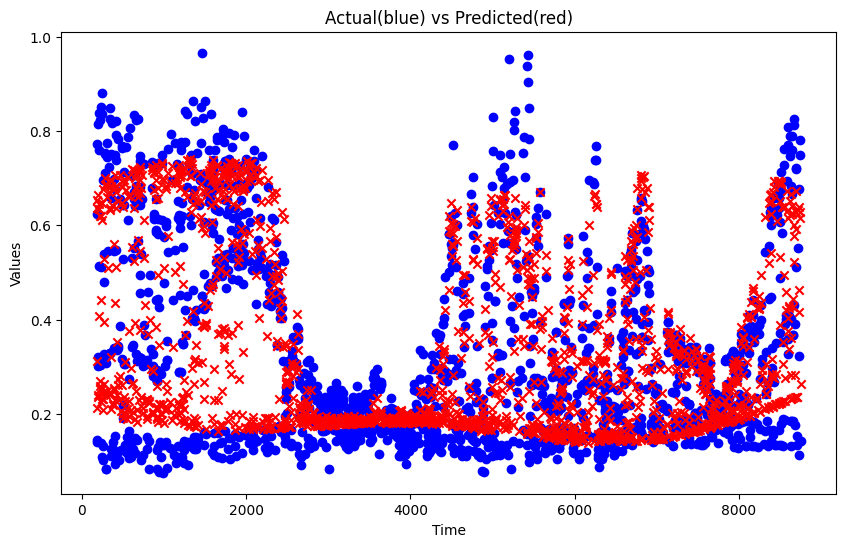

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.scatter( X_test[:,0],y_test,color='blue', marker='o')
plt.scatter(X_test[:,0],y_pred,color='red',  marker='x')
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Actual(blue) vs Predicted(red)')
plt.show()